In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
from tensorflow import keras
import tensorflow as tf

# First model

In [5]:

inx = keras.Input(shape=(25, 240, 320, 3))
x = keras.layers.TimeDistributed(keras.layers.Conv2D(20, (3,3), padding='same', strides=(2,2), activation='relu'))(inx)
x = keras.layers.TimeDistributed(keras.layers.MaxPooling2D())(x)
x = keras.layers.TimeDistributed(keras.layers.Conv2D(40, (3,3), padding='same', strides=(2,2), activation='relu'))(x)
x = keras.layers.TimeDistributed(keras.layers.MaxPooling2D())(x)
x = keras.layers.TimeDistributed(keras.layers.Conv2D(80, (3,3), padding='same', strides=(2,2), activation='relu'))(x)
x = keras.layers.TimeDistributed(keras.layers.MaxPooling2D())(x)
x = keras.layers.TimeDistributed(keras.layers.Conv2D(160, (3,3), padding='same', strides=(2,2), activation='relu'))(x)
# x = keras.layers.TimeDistributed(keras.layers.Flatten())(x)
x = keras.layers.TimeDistributed(keras.layers.GlobalAveragePooling2D())(x)

x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dense(16, activation = "relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

In [6]:
model = keras.Model(inputs=inx, outputs=outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 240, 320, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 25, 120, 160, 40)  1120      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 60, 80, 40)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 30, 40, 80)    28880     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 15, 20, 80)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 8, 10, 160)    115360    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 4, 5, 160)     0     

In [8]:
def weighted_binary_crossentropy(weights):
    def w_binary_crossentropy(y_true, y_pred):
        return tf.keras.backend.mean(tf.nn.weighted_cross_entropy_with_logits(
            y_true,
            y_pred,
            weights,
            name=None
        ), axis=-1)
    return w_binary_crossentropy
wc = tf.losses.CategoricalCrossentropy()
ssgd = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss = weighted_binary_crossentropy(20), optimizer = "sgd", metrics = ["MSE"])

In [10]:
def train_gen():
    kk=-1
    while True:
        kk += 1
        yield np.load("xx_"+str(kk%3000)+".npy"), np.load("yy_"+str(kk%3000)+".npy")
train_gengen = tf.data.Dataset.from_generator(train_gen, args=[], output_types=(tf.float32, tf.float32,), )


In [11]:
for a,b in train_gengen.repeat().take(1):
    print(a.shape, b)
    break

(10, 25, 240, 320, 3) tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


In [12]:
model.fit_generator(generator = train_gengen, steps_per_epoch= 2500, epochs = 10)

C:\Users\woody\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
2500/2500 [==============================] - 562s 221ms/step - loss: 1.4962 - MSE: 0.1330
Epoch 2/10
2500/2500 [==============================] - 570s 228ms/step - loss: 1.5507 - MSE: 0.1879
Epoch 3/10
2500/2500 [==============================] - 574s 229ms/step - loss: 1.5199 - MSE: 0.1392
Epoch 4/10
2500/2500 [==============================] - 583s 233ms/step - loss: 1.5309 - MSE: 0.1480
Epoch 5/10
2500/2500 [==============================] - 581s 232ms/step - loss: 1.5317 - MSE: 0.1592
Epoch 6/10
2500/2500 [==============================] - 562s 225ms/step - loss: 1.4878 - MSE: 0.1768
Epoch 7/10
2500/2500 [==============================] - 571s 228ms/step - loss: 1.3132 - MSE: 0.1833
Epoch 8/10
2500/2500 [==============================] - 564s 225ms/step - loss: 1.2420 - MSE: 0.1046
Epoch 9/10
2500/2500 [==============================] - 573s 229ms/step - loss: 1.2426 - MSE: 0.1240
Epoch 10/10
2500/2500 [==============================] - 578s 231ms/step - loss: 1.3625 - M

## save model

In [19]:
model.save("fall_model.h5")

## load model

In [16]:
model = tf.keras.models.load_model("fall_model.h5", custom_objects={'w_binary_crossentropy': weighted_binary_crossentropy(20)})
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 240, 320, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 25, 120, 160, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 60, 80, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 30, 40, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 15, 20, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 8, 10, 64)     18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 4, 5, 64)      0     

## Result generation

In [21]:
import cv2
nopnew = "FallDataset/Office/Office/video (3).avi"
nofirst = "FallDataset/Coffee_room_01/Coffee_room_01/Videos/video (1).avi"
cap = cv2.VideoCapture(nopnew)
temp = []
for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    _,frame = cap.read()
    temp += [frame if frame.shape == (240,320,3) else cv2.resize(frame,(320,240))]
temp = np.array(temp)
temp_x = []
for i,x in enumerate(temp[:-25]):
    temp_x += [temp[i:i+25]]
temp_x = np.array(temp_x)

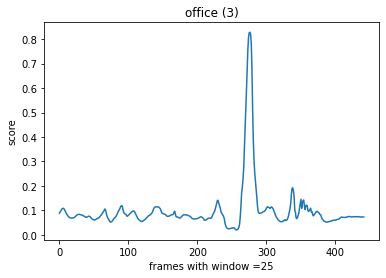

In [22]:
plt.plot(model.predict(temp_x))
plt.ylabel("score")
plt.xlabel("frames with window =25")
plt.title("office (3)")
plt.savefig("office (3)2")

# Second model

In [32]:

inx = keras.Input(shape=(24, 240, 320, 6))
x = keras.layers.TimeDistributed(keras.layers.Conv2D(20, (3,3), padding='same', strides=(1,1), activation='relu'))(inx)
x = keras.layers.TimeDistributed(keras.layers.MaxPooling2D())(x)
x = keras.layers.TimeDistributed(keras.layers.Conv2D(40, (3,3), padding='same', strides=(1,1), activation='relu'))(x)
x = keras.layers.TimeDistributed(keras.layers.MaxPooling2D())(x)
x = keras.layers.TimeDistributed(keras.layers.Conv2D(80, (3,3), padding='same', strides=(1,1), activation='relu'))(x)
x = keras.layers.TimeDistributed(keras.layers.MaxPooling2D())(x)
x = keras.layers.TimeDistributed(keras.layers.Conv2D(160, (3,3), padding='same', strides=(1,1), activation='relu'))(x)
# x = keras.layers.TimeDistributed(keras.layers.Flatten())(x)
x = keras.layers.TimeDistributed(keras.layers.GlobalAveragePooling2D())(x)

x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dense(16, activation = "relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

In [33]:
model2 = keras.Model(inputs=inx, outputs=outputs)

In [34]:
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 240, 320, 6)] 0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 24, 240, 320, 20)  1100      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 24, 120, 160, 20)  0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 24, 120, 160, 40)  7240      
_________________________________________________________________
time_distributed_35 (TimeDis (None, 24, 60, 80, 40)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 24, 60, 80, 80)    28880     
_________________________________________________________________
time_distributed_37 (TimeDis (None, 24, 30, 40, 80)    0   

In [35]:
def weighted_binary_crossentropy(weights):
    def w_binary_crossentropy(y_true, y_pred):
        return tf.keras.backend.mean(tf.nn.weighted_cross_entropy_with_logits(
            y_true,
            y_pred,
            weights,
            name=None
        ), axis=-1)
    return w_binary_crossentropy
wc = tf.losses.CategoricalCrossentropy()
ssgd = tf.keras.optimizers.SGD(learning_rate=0.1)
model2.compile(loss = weighted_binary_crossentropy(20), optimizer = "sgd", metrics = ["MSE"])

In [36]:
def train_gen():
    kk=-1
    while True:
        kk += 1
        yield np.load("flowx_"+str(kk%1300)+".npy"), np.load("flowy_"+str(kk%1300)+".npy").astype(float)
train_gengen = tf.data.Dataset.from_generator(train_gen, args=[], output_types=(tf.float32, tf.float32,), )


In [37]:
for a,b in train_gengen.repeat().take(1):
    print(a.shape, b)
    break

(10, 24, 240, 320, 6) tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


In [38]:
model2.fit_generator(generator = train_gengen, steps_per_epoch= 1000, epochs = 10)

Epoch 1/10
1000/1000 [==============================] - 717s 714ms/step - loss: 1.4840 - MSE: 0.2367
Epoch 2/10
1000/1000 [==============================] - 707s 707ms/step - loss: 1.1178 - MSE: 0.0772
Epoch 3/10
1000/1000 [==============================] - 705s 705ms/step - loss: 1.1281 - MSE: 0.0788
Epoch 4/10
1000/1000 [==============================] - 714s 714ms/step - loss: 1.1153 - MSE: 0.0672
Epoch 5/10
1000/1000 [==============================] - 713s 713ms/step - loss: 1.1548 - MSE: 0.0846
Epoch 6/10
1000/1000 [==============================] - 715s 715ms/step - loss: 1.1005 - MSE: 0.0746
Epoch 7/10
1000/1000 [==============================] - 717s 717ms/step - loss: 1.1500 - MSE: 0.0733
Epoch 8/10
1000/1000 [==============================] - 715s 715ms/step - loss: 1.0933 - MSE: 0.0638
Epoch 9/10
1000/1000 [==============================] - 714s 714ms/step - loss: 1.1347 - MSE: 0.0756
Epoch 10/10
1000/1000 [==============================] - 711s 711ms/step - loss: 1.1273 - M

## save model

In [39]:
model2.save("flowmodel.h5")

## load model

In [ ]:
model = tf.keras.models.load_model("flowmodel.h5", custom_objects={'w_binary_crossentropy': weighted_binary_crossentropy(20)})
model.summary()

## Result generation

In [64]:
import cv2
nopnew = "FallDataset/Office/Office/video (5).avi"
nofirst = "FallDataset/Coffee_room_01/Coffee_room_01/Videos/video (1).avi"
cap = cv2.VideoCapture(nopnew)
temp = []
for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    _,frame = cap.read()
    temp += [frame if frame.shape == (240,320,3) else cv2.resize(frame,(320,240))]
temp_t = []
for i in range(len(temp)-1):
    temp_tt = cv2.calcOpticalFlowFarneback(temp[i][:,:,0], temp[i+1][:,:,0], None, 0.5, 3, 15, 3, 5, 1.2, 0)
    temp_tt = np.concatenate((temp_tt, cv2.calcOpticalFlowFarneback(temp[i][:,:,1], temp[i+1][:,:,1], None, 0.5, 3, 15, 3, 5, 1.2, 0)),axis=-1)
    temp_tt = np.concatenate((temp_tt, cv2.calcOpticalFlowFarneback(temp[i][:,:,2], temp[i+1][:,:,2], None, 0.5, 3, 15, 3, 5, 1.2, 0)),axis=-1)
    temp_t += [temp_tt]
temp = temp_t
temp_x = []
for i,x in enumerate(temp[:-24]):
    temp_x += [temp[i:i+24]]
temp_x = np.array(temp_x)

In [65]:
temp_x.shape

(213, 24, 240, 320, 6)

In [66]:
flow_plot = []
for i in range(len(temp_x)-1):
    flow_plot+=[model2.predict(temp_x[i:i+1])[0][0]]

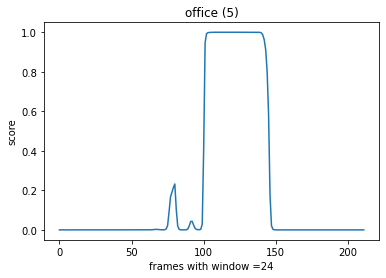

In [67]:
plt.plot(flow_plot)
plt.ylabel("score")
plt.xlabel("frames with window =24")
plt.title("office (5)")
plt.savefig("office (5) with flow")